In [22]:
# tf tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# cifar10 data - 32x32
#from tensorflow.keras.datasets import cifar10

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import zipfile
import shutil

## Unzipping

In [2]:
    folder_path_train = os.path.join("..", "data", "asl_alphabet_train", "asl_alphabet_train") # Path to the data if unzipped already
    if not os.path.exists(folder_path_train): # Checking to see if folder is unzipped
        print("Unzipping file...")
        path_to_zip = os.path.join("..","data","archive1.zip") # Defining the path to the zip file
        zip_destination = os.path.join("..", "data") # defining the output destination

        with zipfile.ZipFile(path_to_zip,"r") as zip_ref: # using the package from zipfile, to un zip the zip file
            zip_ref.extractall(zip_destination)
    print("The files are unzipped")

The files are unzipped


## Unzipping test images

In [3]:
    folder_path_test = os.path.join("..", "data", "real_test_images") # Path to the data if unzipped already
    if not os.path.exists(folder_path_test): # Checking to see if folder is unzipped
        print("Unzipping file")
        os.makedirs(folder_path) # Making the folder real_test_images
        path_to_zip = os.path.join("..","data","archive2.zip") # Defining the path to the zip file
        zip_destination = os.path.join("..", "data", "real_test_images") # defining the output destination

        with zipfile.ZipFile(path_to_zip,"r") as zip_ref: # using the package from zipfile, to un zip the zip file
            zip_ref.extractall(zip_destination)
    print("The files are unzipped")

Unzipping file


NameError: name 'folder_path' is not defined

## Deleting folders

### Deleting folders for real_test_images
- folder_path_train and folder_path_test is used 

In [23]:

folders_to_delete = ["asl-alphabet-test", "del", "nothing", "space"]  # List of folders to delete

for folder_name in folders_to_delete:
    folder_path = os.path.join(folder_path_train, folder_name) # Getting folder_path_test from unzip function 
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
        print(f"Deleted folder: {folder_path}")
    else:
        print(f"Folder: {folder_path} does not exists")

folder_path_asl_test = os.path.join("..","data","asl_alphabet_test")
if os.path.exists(folder_path_asl_test):
    shutil.rmtree(folder_path_asl_test)
    print(f"Deleted folder_ {folder_path_asl_test}")
else:
    print(f"{folder_path_asl_test} is already deleted")

Folder: ../data/asl_alphabet_train/asl_alphabet_train/asl-alphabet-test does not exists
Folder: ../data/asl_alphabet_train/asl_alphabet_train/del does not exists
Folder: ../data/asl_alphabet_train/asl_alphabet_train/nothing does not exists
Folder: ../data/asl_alphabet_train/asl_alphabet_train/space does not exists
../data/asl_alphabet_test is already deleted


## Train and validation generator 

In [5]:

    print("Creating Image data generator")
    # ImageDataGenerator from tensorflow 
    datagen = ImageDataGenerator(horizontal_flip=True,
                                validation_split = 0.2, # Flip it horizontally around the access randomly 
                                 # Rotate the image randomly 20 degress around the access
                                rescale = 1/255 # rescale the pixel values to between 0-1
                                
    )


Creating Image data generator


## dataframe creation for train images for enabling sampling

In [24]:

# Set the path to the directory containing your data
data_dir = os.path.join("..","data","asl_alphabet_train","asl_alphabet_train")



# Initialize lists to store image paths and labels
image_paths = []
labels = []
images = []

# Iterate through each letter folder in the data directory
for label_folder in os.listdir(data_dir):
    letter_folder = os.path.join(data_dir, label_folder)

    # Iterate through each image file in the letter folder
    for filename in os.listdir(letter_folder):
        image_path = os.path.join(letter_folder, filename)
        images.append(image_path)
        # Append the image path and label to the respective lists
        image_paths.append(image_path)
        labels.append(label_folder)

# Create a DataFrame from the image_paths and labels lists
train_df = pd.DataFrame({'image_path': image_paths, 'label': labels})
len(train_df)

78000

## Creating a dataframe for test images from train images

In [25]:
test_images_dataframe = pd.DataFrame(columns = ["image_path", "label"]) # Creating empty dataframe

labels_grouped = train_df.groupby("label") # Grouping the dataframe by label

for label, group in labels_grouped: # takes the first 100 of each label and concatinates them into the new dataframe
    test_images = group.head(1000)
    test_images_dataframe = pd.concat([test_images_dataframe, test_images]) 

train_df = train_df.drop(test_images_dataframe.index) # Removing the images with the same index

In [26]:
len(train_df)

52000

### Sampling

In [27]:
train_df = train_df.sample(n=26000)

## Train from dataframe

In [28]:
training_tensorflow = datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(90, 90),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset = "training",
    seed=None,
    interpolation='nearest',
    keep_aspect_ratio=False
)

#["A","B","C","D","E","F","G","H","J","K","L","M","N","P","Q","R","S","T","U","V","W","X","Y","Z"],

Found 20800 validated image filenames belonging to 26 classes.


## Train from dir

In [6]:
training_tensorflow = datagen.flow_from_directory(
    folder_path_train, # Getting folder from un zip function
    target_size=(90, 90),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=None,
    #save_to_dir=None,
    #save_prefix='',
    #save_format='png',
    #follow_links=False,
    subset="training",
    interpolation='nearest',
    keep_aspect_ratio=False
)

Found 62400 images belonging to 26 classes.


In [65]:
validation_tensorflow = datagen.flow_from_dataframe(
    train_df,
    directory=None,
    x_col='image_path',
    y_col='label',
    target_size=(90, 90),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    subset = "validation",
    seed=None,
    interpolation='nearest',
    keep_aspect_ratio=False
)

#["A","B","C","D","E","F","G","H","J","K","L","M","N","P","Q","R","S","T","U","V","W","X","Y","Z"],


Found 5200 validated image filenames belonging to 26 classes.


## Test images

## Test datagenerator 

In [11]:
    test_datagen = ImageDataGenerator(                 
                                    rescale = 1./255. # Datagenerator for test, it only has to rescale the images 
    )

## Test flow from dataframe

In [29]:
test_tensorflow = test_datagen.flow_from_dataframe(
    test_images_dataframe,
    directory=None,
    x_col='image_path',
    target_size=(90, 90),
    color_mode='rgb',
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=None
)

#["A","B","C","D","E","F","G","H","J","K","L","M","N","P","Q","R","S","T","U","V","W","X","Y","Z"],

Found 26000 validated image filenames.


## Test flow from dir

In [11]:
test_tensorflow_ = test_datagen.flow_from_directory(
    folder_path_test,
    target_size=(90, 90),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=128,
    shuffle=True,
    seed=None,
    #save_to_dir=None,
    #save_prefix='',
    #save_format='png',
    #follow_links=False,
    subset=None,
    interpolation='nearest',
    keep_aspect_ratio=False
)

Found 780 images belonging to 26 classes.


In [68]:

    print("Loading model: ")  
    # load model without classifier layers
    model = VGG16(include_top=False, # Exclude classifier layers
                pooling='avg',
                input_shape=(90, 90, 3)) # Input shape of the images. 224 pixels by 224. 3 color channels

    # Keep pretrained layers, and don't modify them
    for layer in model.layers:
        layer.trainable = False
        
    # Add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    bn = BatchNormalization()(flat1) # Added batnormalization from tensorflow. Take the previouslayer, normalise the values, and than pass them on
    class1 = Dense(256, 
                activation='relu')(bn) # Added new classification layer 
    class2 = Dense(128, 
                activation='relu')(class1) # Added new classification layer with 15 outputs. 15 labels in total
    output = Dense(26, # 15 labels
                activation='softmax')(class2)

    # define new model
    model = Model(inputs=model.inputs, 
                outputs=output)

    # compile
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, # Start learning rate at 0.01
        decay_steps=10000, # Every 10 000 steps start decaying 
        decay_rate=0.9) # DEcay by 0.9 to the start learning rate
    sgd = SGD(learning_rate=lr_schedule)

    model.compile(optimizer=sgd,
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    # summarize
    print(model.summary())
    

Loading model: 
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 90, 90, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 90, 90, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 90, 90, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 45, 45, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 45, 45, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 45, 45, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 22, 22,

In [69]:
    H = model.fit( # fitting the model to 
        training_tensorflow, # training data from tensorflow dataframe 
        steps_per_epoch = len(training_tensorflow), # Take as many steps as the length of the dataframe 
        validation_data = validation_tensorflow, # Validation data from tensorflow dataframe
        validation_steps = len(validation_tensorflow), # Validation steps as length of validation data 
        epochs = 5)

Epoch 1/5


2023-05-20 14:10:12.444530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


650/650 [==============================] - ETA: 0s - loss: 2.2040 - accuracy: 0.4226

2023-05-20 14:23:36.714593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


650/650 [==============================] - 1127s 2s/step - loss: 2.2040 - accuracy: 0.4226 - val_loss: 1.2977 - val_accuracy: 0.7058
Epoch 2/5
650/650 [==============================] - 1231s 2s/step - loss: 0.9932 - accuracy: 0.7457 - val_loss: 0.6926 - val_accuracy: 0.8237
Epoch 3/5
650/650 [==============================] - 300s 462ms/step - loss: 0.6321 - accuracy: 0.8330 - val_loss: 0.4652 - val_accuracy: 0.8794
Epoch 4/5
650/650 [==============================] - 139s 214ms/step - loss: 0.4699 - accuracy: 0.8732 - val_loss: 0.3595 - val_accuracy: 0.9090
Epoch 5/5
650/650 [==============================] - 138s 213ms/step - loss: 0.3785 - accuracy: 0.8974 - val_loss: 0.3017 - val_accuracy: 0.9231


## Predictions

In [30]:
#loading model
model = tf.keras.models.load_model(os.path.join("..","models","real_model.keras")) # Loading in the saved model
model.summary() # Getting the model summary
    

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 90, 90, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 90, 90, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 90, 90, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 45, 45, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 45, 45, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 45, 45, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 22, 22, 128)       0     

In [31]:
    pred = model.predict(test_tensorflow) # Using test data on the model
    pred = np.argmax(pred,axis=1)

    # Map the label 
    labels = (training_tensorflow.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

2023-05-21 17:38:36.406923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


813/813 [==============================] - 1492s 2s/step


## Classifier report

In [32]:
true_labels = test_images_dataframe["label"].values
report = classification_report(true_labels, pred)
print(report)

              precision    recall  f1-score   support

           A       0.90      0.94      0.92      1000
           B       0.91      0.97      0.94      1000
           C       0.98      0.99      0.99      1000
           D       1.00      0.94      0.97      1000
           E       0.96      0.92      0.94      1000
           F       1.00      0.96      0.98      1000
           G       0.96      0.97      0.96      1000
           H       0.96      0.97      0.97      1000
           I       0.95      0.94      0.95      1000
           J       0.96      0.96      0.96      1000
           K       0.94      0.94      0.94      1000
           L       0.98      0.98      0.98      1000
           M       0.92      0.89      0.90      1000
           N       0.95      0.86      0.90      1000
           O       0.97      0.99      0.98      1000
           P       0.99      0.95      0.97      1000
           Q       0.99      0.97      0.98      1000
           R       0.89    

In [33]:
folder_path = os.path.join("..","out") # Saving in folder models
file_name = "real_classification_report_1000.txt" # Name of the file
file_path = os.path.join(folder_path, file_name)

with open(file_path, "w") as f: # "Writing" the classifier metrics, thereby saving it.
    f.write(report)
print("Reports saved")

Reports saved


## Plotting history 

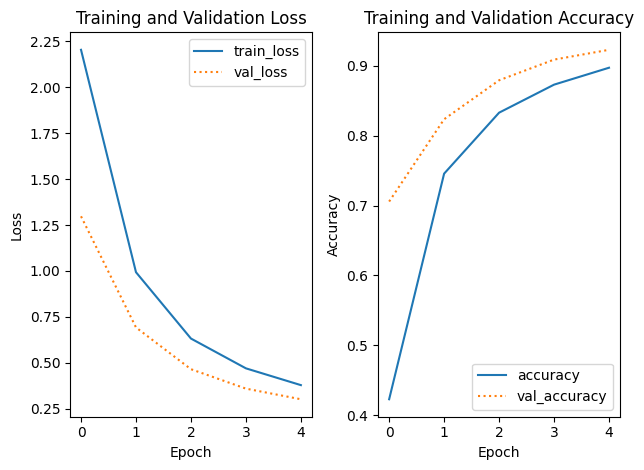

In [75]:

# Plotting the loss
plt.subplot(1, 2, 1)
plt.plot(np.arange(0, 5), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 5), H.history["val_loss"], label="val_loss", linestyle=":")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()

# Plotting the accuracy
plt.subplot(1, 2, 2)
plt.plot(np.arange(0, 5), H.history["accuracy"], label="accuracy")
plt.plot(np.arange(0, 5), H.history["val_accuracy"], label="val_accuracy", linestyle=":")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Adjusting the layout and displaying the plots
plt.tight_layout()
plt.show()


## Test synthetic data

### Loading the data

In [76]:
directory_test = os.path.join("..","data","Test_Alphabet")

In [77]:
test_tensorflow_ = test_datagen.flow_from_directory(
    directory_test,
    target_size=(90, 90),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=None,
    #save_to_dir=None,
    #save_prefix='',
    #save_format='png',
    #follow_links=False,
    interpolation='nearest',
    keep_aspect_ratio=False
)

Found 2600 images belonging to 26 classes.


### Testing

In [78]:
# Code taken from source in readme file
# Testing the model
print("Testing model with test images")
# Predict the label of the test_images
pred = model.predict(test_tensorflow_) # Using test data on the model
pred = np.argmax(pred,axis=1)

# Map the label 
labels = (training_tensorflow.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]


Testing model with test images


2023-05-20 15:12:31.662195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


82/82 [==============================] - 207s 3s/step


### Classification report

In [79]:
true_labels = test_tensorflow_.classes

# Convert labels to numerical values
label_map = {v: k for k, v in training_tensorflow.class_indices.items()}
true_labels = np.array([label_map[label] for label in true_labels])

# Print the classification report
print(classification_report(true_labels, pred))


              precision    recall  f1-score   support

           A       0.08      0.05      0.06       100
           B       0.25      0.14      0.18       100
           C       0.11      0.01      0.02       100
           D       0.03      0.03      0.03       100
           E       0.12      0.42      0.18       100
           F       0.07      0.08      0.07       100
           G       0.16      0.17      0.16       100
           H       0.44      0.04      0.07       100
           I       0.07      0.11      0.09       100
           J       0.03      0.12      0.05       100
           K       0.06      0.37      0.10       100
           L       0.11      0.17      0.13       100
           M       0.05      0.01      0.02       100
           N       0.09      0.08      0.08       100
           O       0.36      0.09      0.14       100
           P       0.12      0.01      0.02       100
           Q       0.10      0.01      0.02       100
           R       0.16    

## Saving Model

In [ ]:

folder_path = os.path.join("..","models", "real_model.keras") # Defining out path
tf.keras.models.save_model( # Using Tensor Flows function for saving models.
model, folder_path, overwrite=False, save_format=None 
) # Model name, folder, Overwrite existing saves, save format = none 